## Setup

### Package Imports and Options

In [1]:
from os import getcwd
import glob
from pprint import pprint

import pandas as pd
import numpy as np
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
import edward as ed

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)

### Load Data

In [3]:
dic = pd.read_excel('data/LCDataDictionary.xlsx')

In [4]:
csv_files = glob.glob(f'{getcwd()}/data/*.csv')
df_raw = pd.concat((pd.read_csv(f, header=1, low_memory=False) for f in csv_files))

In [5]:
df = df_raw

### Overview + Preprocessing

The goal of this analysis is to create a trivial model to predict default or deliquency rates for borrowers in the Lending Club dataset. This model will serve as a starting point for more robust analysis. 

The Lending Club dataset provides a field called `loan_status` which reports whether loans are fully paid, current, delinquent or in default, etc. This is our variable of interest.

In [6]:
loan_status = df.loan_status

In [7]:
loan_status.value_counts()

Fully Paid                                             914248
Current                                                801148
Charged Off                                            229295
Late (31-120 days)                                     21659 
Issued                                                 13621 
In Grace Period                                        11519 
Late (16-30 days)                                      6230  
Does not meet the credit policy. Status:Fully Paid     1988  
Default                                                1015  
Does not meet the credit policy. Status:Charged Off    761   
Name: loan_status, dtype: int64

To start, I will just use a few of the features that seem relevant based on my limited domain knowledge:

In [8]:
features = ['loan_status', 'annual_inc', 'avg_cur_bal', 'int_rate', 
            'emp_length', 'funded_amnt', 'grade', 'home_ownership', 
            'loan_amnt', 'term', 'installment', 'verification_status', 
            'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 
            'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'sub_grade']

In [9]:
dic[dic['LoanStatNew'].isin(features)]

,LoanStatNew,Description
4,annual_inc,The self-reported annual income provided by the borrower during registration.
7,avg_cur_bal,Average current balance of all accounts
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
23,funded_amnt,The total amount committed to that loan at that point in time.
25,grade,LC assigned loan grade
26,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
32,inq_last_6mths,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
33,installment,The monthly payment owed by the borrower if the loan originates.


In [10]:
df = df[features]

In [11]:
df.shape

(2001513, 22)

The plot below indicates missing values / value counts for the observed features.  There are not too many relative to the size of our dataset (~20k compared to 2m) so I am dropping them for the time being.

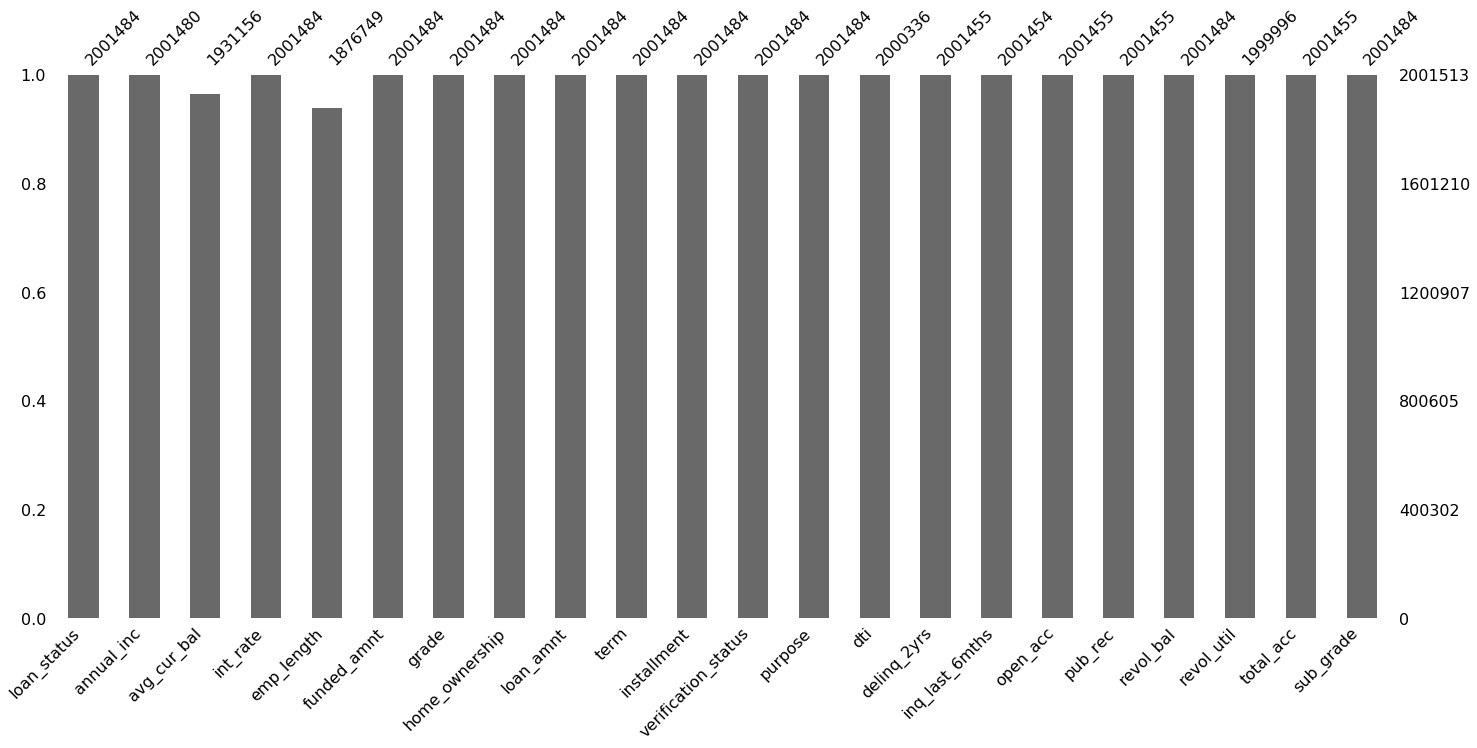

In [12]:
msno.bar(df)

In [13]:
df.dropna(inplace=True)

/Users/basilvetas/.local/share/virtualenvs/lending-club-analysis-iUojZaP3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
df.shape

(1807209, 22)

In [15]:
df.dtypes

loan_status            object 
annual_inc             float64
avg_cur_bal            float64
int_rate               object 
emp_length             object 
funded_amnt            float64
grade                  object 
home_ownership         object 
loan_amnt              float64
term                   object 
installment            float64
verification_status    object 
purpose                object 
dti                    float64
delinq_2yrs            float64
inq_last_6mths         float64
open_acc               float64
pub_rec                float64
revol_bal              float64
revol_util             object 
total_acc              float64
sub_grade              object 
dtype: object

We need to encode the target feature as integers rather than strings

In [16]:
le = preprocessing.LabelEncoder()
loan_status = le.fit_transform(df.loan_status)

For simplicity, I'm going to drop the non-numeric features until I have more time to encode them

In [17]:
df = df.select_dtypes(include=['float64'])
df['loan_status'] = loan_status

In [18]:
df.shape

(1807209, 13)

In [19]:
df.dtypes

annual_inc        float64
avg_cur_bal       float64
funded_amnt       float64
loan_amnt         float64
installment       float64
dti               float64
delinq_2yrs       float64
inq_last_6mths    float64
open_acc          float64
pub_rec           float64
revol_bal         float64
total_acc         float64
loan_status       int64  
dtype: object

Only using a subset of the data while debugging/getting things to work

In [20]:
df_full = df

In [58]:
debug = False

In [59]:
if debug:
    np.random.seed = 0
    random_index = np.random.choice(df.shape[0], size=10000, replace=False)
    df = df.iloc[random_index]
else: 
    df = df_full

In [60]:
df.shape

(1807209, 13)

## Bayesian Linear Regression

In [61]:
# Reference: http://edwardlib.org/tutorials/supervised-regression

tf.reset_default_graph()
tf.InteractiveSession().close()
sess = tf.InteractiveSession()

### Data

To begin, I will just try running a simple model with the typical train-test split.  However important to note that this way of splitting the data randomly does not capture the time variance of the features.  As the model becomes more robust, we should only be trying to predict the `loan_status` for a given observation using samples that occurred in the past.  This is a flaw of the current trivial model. 

In [62]:
split = np.random.rand(df.shape[0]) < 0.9
df_train = df[split]
df_test = df[~split]

X_train = df_train.drop('loan_status', axis=1)
y_train = df_train['loan_status'].values
X_test = df_test.drop('loan_status', axis=1)
y_test = df_test['loan_status'].values

N = X_train.shape[0]  # number of data points
D = X_train.shape[1]  # number of features

In [63]:
X_train.shape

(1626235, 12)

In [64]:
X_test.shape

(180974, 12)

In [65]:
y_train.shape

(1626235,)

In [66]:
y_test.shape

(180974,)

### Model

To start, we posit the model as a Bayesian Linear Regression with Normal priors. 

In [67]:
from edward.models import Normal

X = tf.placeholder(tf.float32, [None, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(1))

### Inference

We now infer the posterior using VI. We define the model to be a fully factorized normal across the weights.

In [68]:
qw = Normal(loc=tf.get_variable("qw/loc", [D]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))

qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

We run VI with the KL divergence, using 250 iterations and 5 latent variable samples.

In [69]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})

In [70]:
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 36s | Loss: 34426641711104.000


### Criticism

We first form the posterior distribution

In [71]:
y_post = ed.copy(y, {w: qw, b: qb})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

In [73]:
print("MSE on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("MAE on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))


MSE on test data:
52934.39
MAE on test data:
250.94684
